In [1]:
import json
from models import Darknet
from train import hyp
from utils import torch_utils
from adapter import loss_func, get_y_func, load_voc, has_person, json_to_paths, create_split_func, YoloCategoryList
from utils.utils import compute_loss, build_targets, bbox_iou, ap_per_class
from fastai.vision import *

In [2]:
images = load_voc()

In [3]:
# Build lists of positive and negative samples
positive_samp = [img for img in images.values() if has_person(img)]
negative_samp = [img for img in images.values() if not has_person(img)]
f"{len(positive_samp)}; {len(negative_samp)}"

'8566; 12937'

In [4]:
# Truncate negative samples to be roughly same length as positive
negative_samp = negative_samp[:len(positive_samp)]
len(negative_samp)

8566

In [5]:
# Combine sample sets back together
samples = positive_samp #+ negative_samp

In [6]:
# Load the model
img_size = (352, 608)
device = 'cuda:0'
arc = 'default'
cfg = 'cfg/yolov3-tiny-anchors.cfg'
weights = 'weights/best.pt'
device = torch_utils.select_device(device, apex=False, batch_size=64)
model = Darknet(cfg, img_size=img_size, arc=arc).to(device)
model.arc = 'default'
model.nc = 1  # num classes
model.hyp = hyp
model.load_state_dict(torch.load(weights, map_location=device)['model'])

# Build the paths and pass them to the FastAI ObjectItemList
posix_paths = json_to_paths(samples)
lst = ObjectItemList(posix_paths, label_cls=YoloCategoryList)
YoloCategoryList.anchors = [model.module_list[l].anchors for l in model.yolo_layers]
YoloCategoryList.img_size = img_size

Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2070 with Max-Q Design', total_memory=7982MB)



In [7]:
# Turn all this into a FastAI DataBunch so we can train
data = (lst
        .split_by_valid_func(create_split_func(samples))
        .label_from_func(partial(get_y_func, images))
        .transform(
            get_transforms(),
            tfm_y=True,
            size=img_size,
            resize_method=ResizeMethod.PAD,
            padding_mode='zeros'
        )
        .databunch(bs=16, collate_fn=bb_pad_collate))

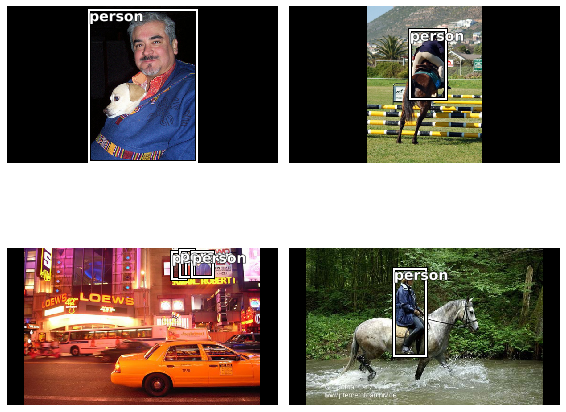

In [8]:
# Show the images so we can visually validate
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(8,8))

In [15]:
# Create custom metric
class ApAt50(Callback):

    def __init__(self):
        self.stats = []
        self.apAt50 = 0

    def on_epoch_begin(self, **kwargs):
        self.stats = []
        self.apAt50 = 0

    def on_batch_end(self, last_output, last_target, **kwargs):
        bs = last_output[0].shape[0]
        iou_thres = torch.tensor((0.5,))
        niou = iou_thres.numel()
        for batch_idx in range(0, bs):
            target_boxes = last_target[0][batch_idx].cpu()
            target_classes = last_target[1][batch_idx].cpu() - 1.0
            people_idxs = (torch.LongTensor((0,)) == target_classes).nonzero().view(-1)
            target_boxes = target_boxes[people_idxs]
            target_classes = target_classes[people_idxs]
            yolo_out = grab_idx(last_output, batch_idx)
            pred = YoloCategoryList.yolo2pred(yolo_out)  # list([[x1, y1, x2, y2, conf, cls]])
            detections = pred[0]
            if detections is None:  # bs=1, first and only result
                if len(target_classes):
                    self.stats.append((torch.zeros(0, 1), torch.Tensor(), torch.Tensor(), target_classes))
                continue
            boxes = YoloCategoryList.bbox2fai(detections)
            correct = torch.zeros(len(detections), niou)
            if len(target_classes):
                for det_idx, det in enumerate(detections):  # detections per image
                    # Break if all targets already located in image
                    pbox = boxes[det_idx]
                    iou, j = bbox_iou(pbox, target_boxes).max(0)
                    correct[det_idx] = iou > iou_thres
            conf = detections[:, 4]
            clazz = detections[:, 5]
            self.stats.append((correct, conf, clazz, target_classes))
        stats = [np.concatenate(x, 0) for x in list(zip(*self.stats))]  # to numpy
        p, r, ap, f1, ap_class = ap_per_class(*stats)
        self.apAt50 = ap.item()

    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self.apAt50)


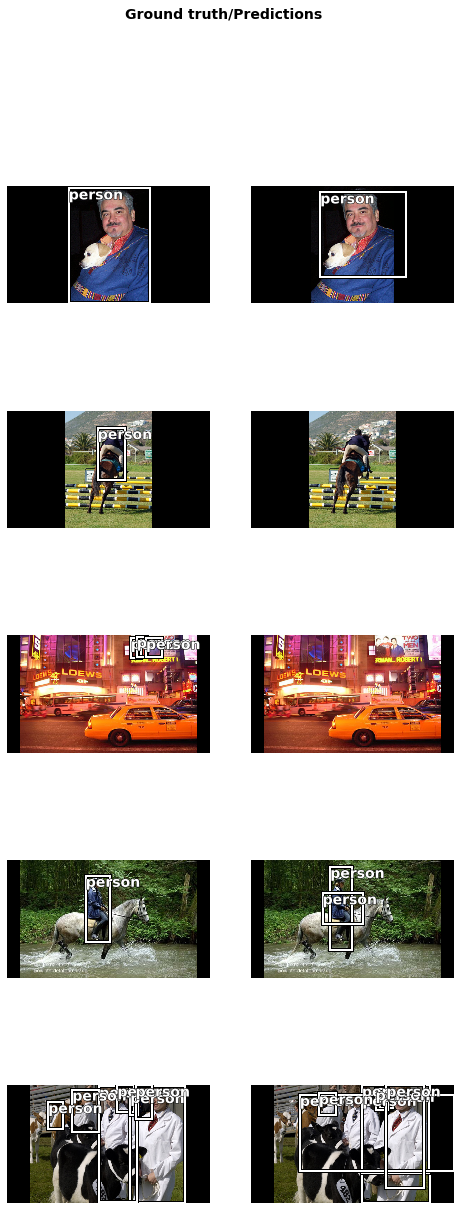

In [16]:
# Finally we have everything we need to make a learner
metrics = [ApAt50()]
learner = Learner(data, model, loss_func=partial(loss_func, model), metrics=metrics)
learner.show_results(rows=5)

In [17]:
# test custom metrics
epochs = 1
callbacks = []
cb_handler = CallbackHandler(callbacks, metrics)
pbar = master_bar(range(epochs))
cb_handler.on_train_begin(epochs, pbar=pbar, metrics=metrics)
val_loss = validate(learner.model, learner.data.valid_dl, loss_func=learner.loss_func,
                    cb_handler=cb_handler, pbar=pbar)

AttributeError: 'NBMasterBar' object has no attribute 'out'

In [18]:
# lr_find(learner)

In [19]:
# learner.recorder.plot()

In [20]:
fit_one_cycle(learner, 1, max_lr=0.0)

epoch,train_loss,valid_loss,ap_at50,time
0,10.171003,9.950693,0.000000,01:06


In [ ]:
from utils.torch_utils import model_info
model_info(model)